In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from PIL import Image
import glob
import shap
import keras
from tensorflow.keras import optimizers
from keras import backend as K
K.set_image_data_format("channels_last")
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf

#%matplotlib inline
%load_ext autoreload
%autoreload 2

np.set_printoptions(threshold=np.inf)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The images were pre-processed (cropped, straightened, etc) as they came from various sources. 

In [15]:
final_dir = "train/real/" 
real = glob.glob('train/real/*.jpg') + glob.glob('train/real/*.png')
prev = (0,0)
for i, filename in enumerate(real): #resize and save 
    file_name = filename.split("/")[2]
    img = Image.open(filename)

    # Save image or feed directly to tensorflow 
    #img.save(final_dir+file_name) 
    
    if i == 0 or prev != img.size: #outputs all the different sizes found if consecutive ones are different
        print("image dimensions: " + str(img.size))
        prev = img.size


image dimensions: (712, 481)
image dimensions: (1891, 1280)
image dimensions: (712, 481)
image dimensions: (1231, 833)
image dimensions: (3283, 2238)
image dimensions: (1179, 798)
image dimensions: (4000, 2662)
image dimensions: (778, 526)
image dimensions: (997, 674)
image dimensions: (990, 670)
image dimensions: (784, 530)
image dimensions: (1126, 762)
image dimensions: (3277, 2251)
image dimensions: (5504, 3800)
image dimensions: (3697, 2500)
image dimensions: (4340, 2937)
image dimensions: (3654, 2515)
image dimensions: (769, 520)
image dimensions: (1460, 988)
image dimensions: (1189, 804)
image dimensions: (5290, 3446)
image dimensions: (4017, 2763)
image dimensions: (711, 481)
image dimensions: (1887, 1277)
image dimensions: (1962, 1328)
image dimensions: (1173, 794)
image dimensions: (1955, 1323)
image dimensions: (1325, 908)
image dimensions: (1351, 928)


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        './train/',  # This is the source directory for training images
        classes = ['real', 'fake'],
        target_size=(400, 400),  # All images will be resized to 400x400
        batch_size=10,
        shuffle = False,
        class_mode='binary')     # Use binary labels


# Flow validation images using valid_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        './valid/',  # This is the source directory for training images
        classes = ['real', 'fake'],
        target_size=(400, 400),  # All images will be resized to 400x400
        batch_size=3,
        class_mode='binary', # Use binary labels
        shuffle=False)


Found 54 images belonging to 2 classes.
Found 14 images belonging to 2 classes.


Now we describe the model. There were a few considerations that went into play. Initially, I had created a model with 5 or 6 convolution layers followed by flattening and some fully connected layers.

However, model was performing pretty badly and generally overfitting the training data. Upon further research I realized that over-fitting typically occurs when the ratio of
$\frac{\text{complexity of model}}{\text{training set size}}$ is too high. As such I cut down to 3 convolution layers. Also found that dropout significantly imporved my model. 


In [4]:
model = tf.keras.models.Sequential([
tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(400,400,3)), #remember to change this based on input shape
tf.keras.layers.MaxPooling2D(2, 2),

# 2nd convolution
tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
    
# 3rd convolution
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
  
# flatten
tf.keras.layers.Flatten(),
    
# 512 neuron hidden layer
tf.keras.layers.Dense(512, activation='relu'),
tf.keras.layers.Dropout(0.5), # reduce overfitting training data

# Only 1 output neuron for binary classification
tf.keras.layers.Dense(1, activation='sigmoid')])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


For ease of understanding the number of parameters, shapes, etc., I have outputted the model summary below

In [18]:
print(model.summary() )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 398, 398, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 199, 199, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 197, 197, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 147456)           

In [5]:
model.compile(optimizer = optimizers.RMSprop(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

# if loading weights and re-evaluating model
model.load_weights("./solid_weights.h5")
loss, acc = model.evaluate(validation_generator, verbose=1)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
5/5 [==============================] - 1s 164ms/step - loss: 2.3615 - acc: 0.9286


In [ ]:
epochs = 10
model.compile(optimizer = optimizers.RMSprop(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator,
      steps_per_epoch=5,  # total training ex // batch size
      epochs=epochs,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=4) # total valid ex // batch size

print(model.metrics_names)
print(history.history)
# model.save_weights("fitted_weights.h5")


In [ ]:
plt.figure()
plt.title("Loss")
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'] , color='r', label="Validation loss")
plt.xticks(np.arange(1, epochs, 1))

plt.legend(loc='best', shadow=True)
savepath = os.path.join('.', 'Loss.png')
plt.savefig(fname=savepath, transparent=False, format='png', bbox_inches='tight')
plt.autoscale()  

plt.show()
plt.close()

plt.figure()
plt.title("Accuracy")
plt.plot(history.history['acc'], color='b', label="Training accuracy")
plt.plot(history.history['val_acc'], color='r',label="Validation accuracy")
plt.yticks(np.arange(0, 1, 0.1))
plt.xticks(np.arange(1, epochs, 1))
plt.legend(loc='best', shadow=True)
savepath = os.path.join('.', 'Accuracy.png')
plt.savefig(fname=savepath, transparent=False, format='png', bbox_inches='tight')

plt.show()
plt.close()

In [ ]:
results_test = model.evaluate(validation_generator)
print(results_test)


In [ ]:
STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size
validation_generator.reset()
preds = model.predict(validation_generator,
                      verbose=1)

In [ ]:
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

fpr, tpr, _ = roc_curve(validation_generator.classes, preds)

In [ ]:
roc_auc = auc(fpr, tpr)

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
savepath = os.path.join('.', 'ROC_2.png')
plt.savefig(fname=savepath, transparent=False, format='png', bbox_inches='tight')
plt.show()


### Model Explainer -- Shapley Values

This section explores explaining the model (opening the black box) by providing visualizations of shapley values. We use the entire training set to approximate. 

Found 54 images belonging to 2 classes.



keras is no longer supported, please use tf.keras instead.


None

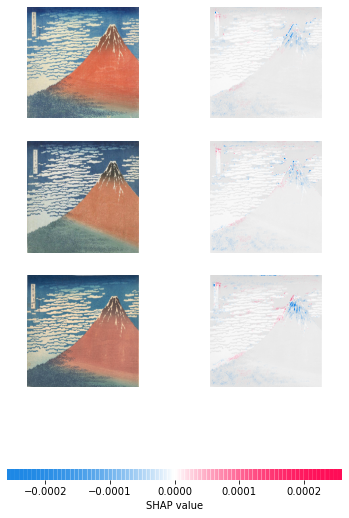

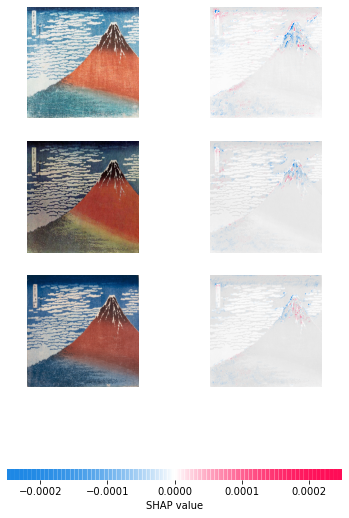

In [6]:
train = train_datagen.flow_from_directory(
        './train/', 
        classes = ['real', 'fake'],
        target_size=(400, 400),  
        shuffle = True,
        class_mode='binary')

classes_val = validation_generator.class_indices # note the labels

x1, y1 = train.next()

background = x1 # used for approximation

x_val1, y_val1 = validation_generator.next()
explainer = shap.DeepExplainer(model, background)
shap_values, = explainer.shap_values(x_val1)

# plot the feature attributions
shap_plot = shap.image_plot(shap_values, x_val1,show=False )
display(shap_plot)
savepath = os.path.join('.', 'validation1.png')
plt.savefig(fname=savepath, transparent=False, format='png', bbox_inches='tight')

x_val2, y_val2 = validation_generator.next()
explainer = shap.DeepExplainer(model,background)
shap_values, = explainer.shap_values(x_val2)

# plot the feature attributions
shap_plot = shap.image_plot(shap_values, x_val2, show=False)
savepath = os.path.join('.', 'validation_SHAP.png')
plt.savefig(fname=savepath, transparent=False, format='png', bbox_inches='tight')
